In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
import configparser
from sqlalchemy import create_engine  
import statsmodels.api as sm

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,FunctionTransformer,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error,mean_absolute_error

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso,Ridge

#Модели регрессии

#Gradient Boosting Regression
from sklearn.ensemble import GradientBoostingRegressor
#Elastic Net Regression
from sklearn.linear_model import ElasticNet
#Stochastic Gradient Descent Regression
from sklearn.linear_model import SGDRegressor
#Support Vector Machine
from sklearn.svm import SVR
#Bayesian Ridge Regression
from sklearn.linear_model import BayesianRidge
#CatBoost Regressor
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
#Kernel Ridge Regression
from sklearn.kernel_ridge import KernelRidge
#Linear Regression
from sklearn.linear_model import LinearRegression
#Ridge and Lasso regression
#XGBoost Regressor
from xgboost import XGBRegressor
#LGBM Regressor
#from lightgbm import LGBMRegressor

# Подбор гиперпараметров
import datetime
from sklearn.metrics import accuracy_score

import pickle
%matplotlib inline



In [2]:
#Ставим кол-во выводимых строк и столбцов 

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

#Отключаем предупреждения

warnings.filterwarnings('ignore')

In [3]:
data_path = '/home/aleksey/Classical_ML/Exploring_Mental_Health_Data/train.csv'

In [4]:
with open(data_path) as f:
    df_train = pd.read_csv(f)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [7]:
df_train.describe().T.style.background_gradient(subset=['std'], cmap='Greens').background_gradient(subset=['mean'], cmap='Reds')

,count,mean,std,min,25%,50%,75%,max
id,140700.000000,70349.500000,40616.735775,0.000000,35174.750000,70349.500000,105524.250000,140699.000000
Age,140700.000000,40.388621,12.384099,18.000000,29.000000,42.000000,51.000000,60.000000
Academic Pressure,27897.000000,3.142273,1.380457,1.000000,2.000000,3.000000,4.000000,5.000000
Work Pressure,112782.000000,2.998998,1.405771,1.000000,2.000000,3.000000,4.000000,5.000000
CGPA,27898.000000,7.658636,1.464466,5.030000,6.290000,7.770000,8.920000,10.000000
Study Satisfaction,27897.000000,2.944940,1.360197,1.000000,2.000000,3.000000,4.000000,5.000000
Job Satisfaction,112790.000000,2.974404,1.416078,1.000000,2.000000,3.000000,4.000000,5.000000
Work/Study Hours,140700.000000,6.252679,3.853615,0.000000,3.000000,6.000000,10.000000,12.000000
Financial Stress,140696.000000,2.988983,1.413633,1.000000,2.000000,3.000000,4.000000,5.000000
Depression,140700.000000,0.181713,0.385609,0.000000,0.000000,0.000000,0.000000,1.000000


In [9]:
#Проверка на дубли

df_train[df_train.duplicated()]

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression


In [14]:
#Функции для создания таблицы по пропускам и визуализации фичей с пропусками

'''
data_frame - Датафрейм который передаем в функцию на проверку
missings_percent - % пустых значений который хотим проверить например missings_percent>0 покажет все колонки где есть пропуски

'''
def missings(data_frame,missings_percent):

    total = data_frame.isnull().sum().sort_values(ascending=False)
    percent = (data_frame.isnull().sum()/data_frame.isnull().count()*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[(missing_data['Percent']>missings_percent)]
    
    return missing_data.style.background_gradient(subset=['Percent'], cmap='Reds')
    
def missings_bar_vizualisation(data_frame,missings_percent):
    
    try:

        total = data_frame.isnull().sum().sort_values(ascending=False)
        percent = (data_frame.isnull().sum()/data_frame.isnull().count()*100).sort_values(ascending=False)
        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        missing_data = missing_data[(missing_data['Percent']>missings_percent)]
    
        #plt.rcParams["figure.figsize"] = (10,5)
        sns.barplot(x=missing_data.index,y=missing_data['Percent'],data = missing_data)
        plt.xticks(rotation=70)
        plt.show()
    
    except ValueError:
        
        print('No missings')

In [15]:
missings(df_train,0)

,Total,Percent
Study Satisfaction,112803,80.172708
Academic Pressure,112803,80.172708
CGPA,112802,80.171997
Profession,36630,26.034115
Work Pressure,27918,19.842217
Job Satisfaction,27910,19.836532
Dietary Habits,4,0.002843
Financial Stress,4,0.002843
Degree,2,0.001421


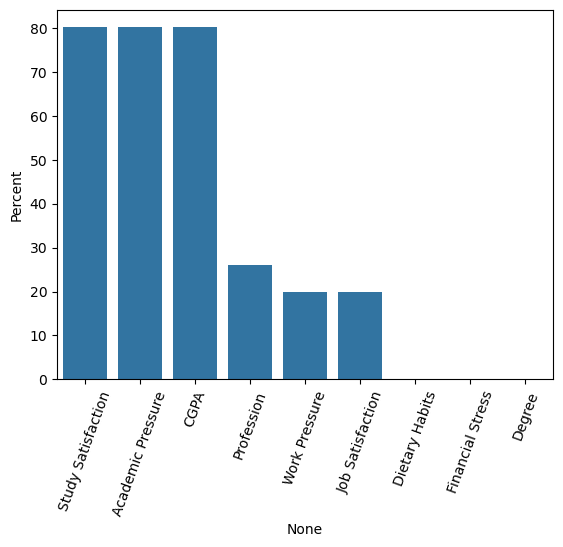

In [16]:
missings_bar_vizualisation(df_train,0)

In [8]:
features = df_train.columns.to_list()
uniques = []
for f in features:
    item = {'feature':f}
    count = len(df_train[f].unique())
    item['count'] = count
    if count < 10:
        item['values'] = df_train[f].unique().tolist()
    elif count < df_train.shape[0]:
        item['values'] = df_train[f].unique().tolist()[:10] + ['...']
    else:
        item['values'] = ['All values are unique']
    uniques.append(item)
df_uniques = pd.DataFrame(uniques)
df_uniques = df_uniques.set_index('feature')

df_uniques.style.background_gradient(subset=['count'], cmap='Reds')

,count,values
feature,,
id,140700,['All values are unique']
Name,422,"['Aaradhya', 'Vivan', 'Yuvraj', 'Rhea', 'Vani', 'Ritvik', 'Rajveer', 'Aishwarya', 'Simran', 'Utkarsh', '...']"
Gender,2,"['Female', 'Male']"
Age,43,"[49.0, 26.0, 33.0, 22.0, 30.0, 59.0, 47.0, 38.0, 24.0, 42.0, '...']"
City,98,"['Ludhiana', 'Varanasi', 'Visakhapatnam', 'Mumbai', 'Kanpur', 'Ahmedabad', 'Thane', 'Nashik', 'Bangalore', 'Patna', '...']"
Working Professional or Student,2,"['Working Professional', 'Student']"
Profession,65,"['Chef', 'Teacher', nan, 'Business Analyst', 'Finanancial Analyst', 'Chemist', 'Electrician', 'Software Engineer', 'Data Scientist', 'Plumber', '...']"
Academic Pressure,6,"[nan, 5.0, 2.0, 3.0, 4.0, 1.0]"
Work Pressure,6,"[5.0, 4.0, nan, 1.0, 2.0, 3.0]"


In [17]:
#Дропним у кого больше percent пропусков

percent = 60

#Записываем таблицу с % пропусков

missings_table = missings(df_train,percent)

#Получаем список колонок на удаление

for_drop = missings_table.index.to_list()

#Удаляем колонки
after_drops = df_train.drop(columns = for_drop)

In [19]:
after_drops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 17 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Work Pressure                          112782 non-null  float64
 8   Job Satisfaction                       112790 non-null  float64
 9   Sleep Duration                         140700 non-null  object 
 10  Dietary Habits                         140696 non-null  

### EDA

In [45]:
#Numeric EDA func

def Numeric_viz(data_frame,cols,cell):

    heart_CAT = data_frame.columns.to_list()

#  Categorical Data

    b = cols  # number of columns
    a = math.ceil(len(heart_CAT)/b)*3  # number of rows
    c = 1  # initialize plot counter

    fig = plt.figure(figsize = (20,50))

    for i in heart_CAT:
        
        if data_frame[i].dtype not in ['object']:
            
            plt.subplot(a, b, c)
            plt.xlabel(i)
            sns.boxplot(data = data_frame, x = i)
            c = c + 1
    
            plt.subplot(a, b, c)
            plt.xlabel(i)
            sns.histplot(data = data_frame, x = i)
            c = c + 1
            
            plt.subplot(a, b, c)
            plt.xlabel(i)
            sns.histplot(data=data_frame, x=i,hue=cell)
            c = c + 1
    fig.tight_layout(h_pad=2,w_pad=2)
    
    plt.show()

In [47]:
def cat_viz(data_frame,cols,cell):

    heart_CAT = data_frame.columns.to_list()

#  Categorical Data

    b = cols  # number of columns
    a = math.ceil(len(heart_CAT)/b)*3  # number of rows
    c = 1  # initialize plot counter

    fig = plt.figure(figsize = (20,50))

    for i in heart_CAT:
        
        if data_frame[i].dtype in ['object']:
            
            plt.subplot(a, b, c)
            plt.xlabel(i)
            sns.countplot(data = data_frame, x = i)
            c = c + 1
            
            plt.subplot(a, b, c)
            plt.xlabel(i)
            sns.histplot(data = data_frame, x = i)
            c = c + 1
            
            plt.subplot(a, b, c)
            plt.xlabel(i)
            sns.countplot(data=data_frame, x=i,hue=cell)
            c = c + 1
        
    fig.tight_layout(h_pad=2,w_pad=2)
    
    plt.show()

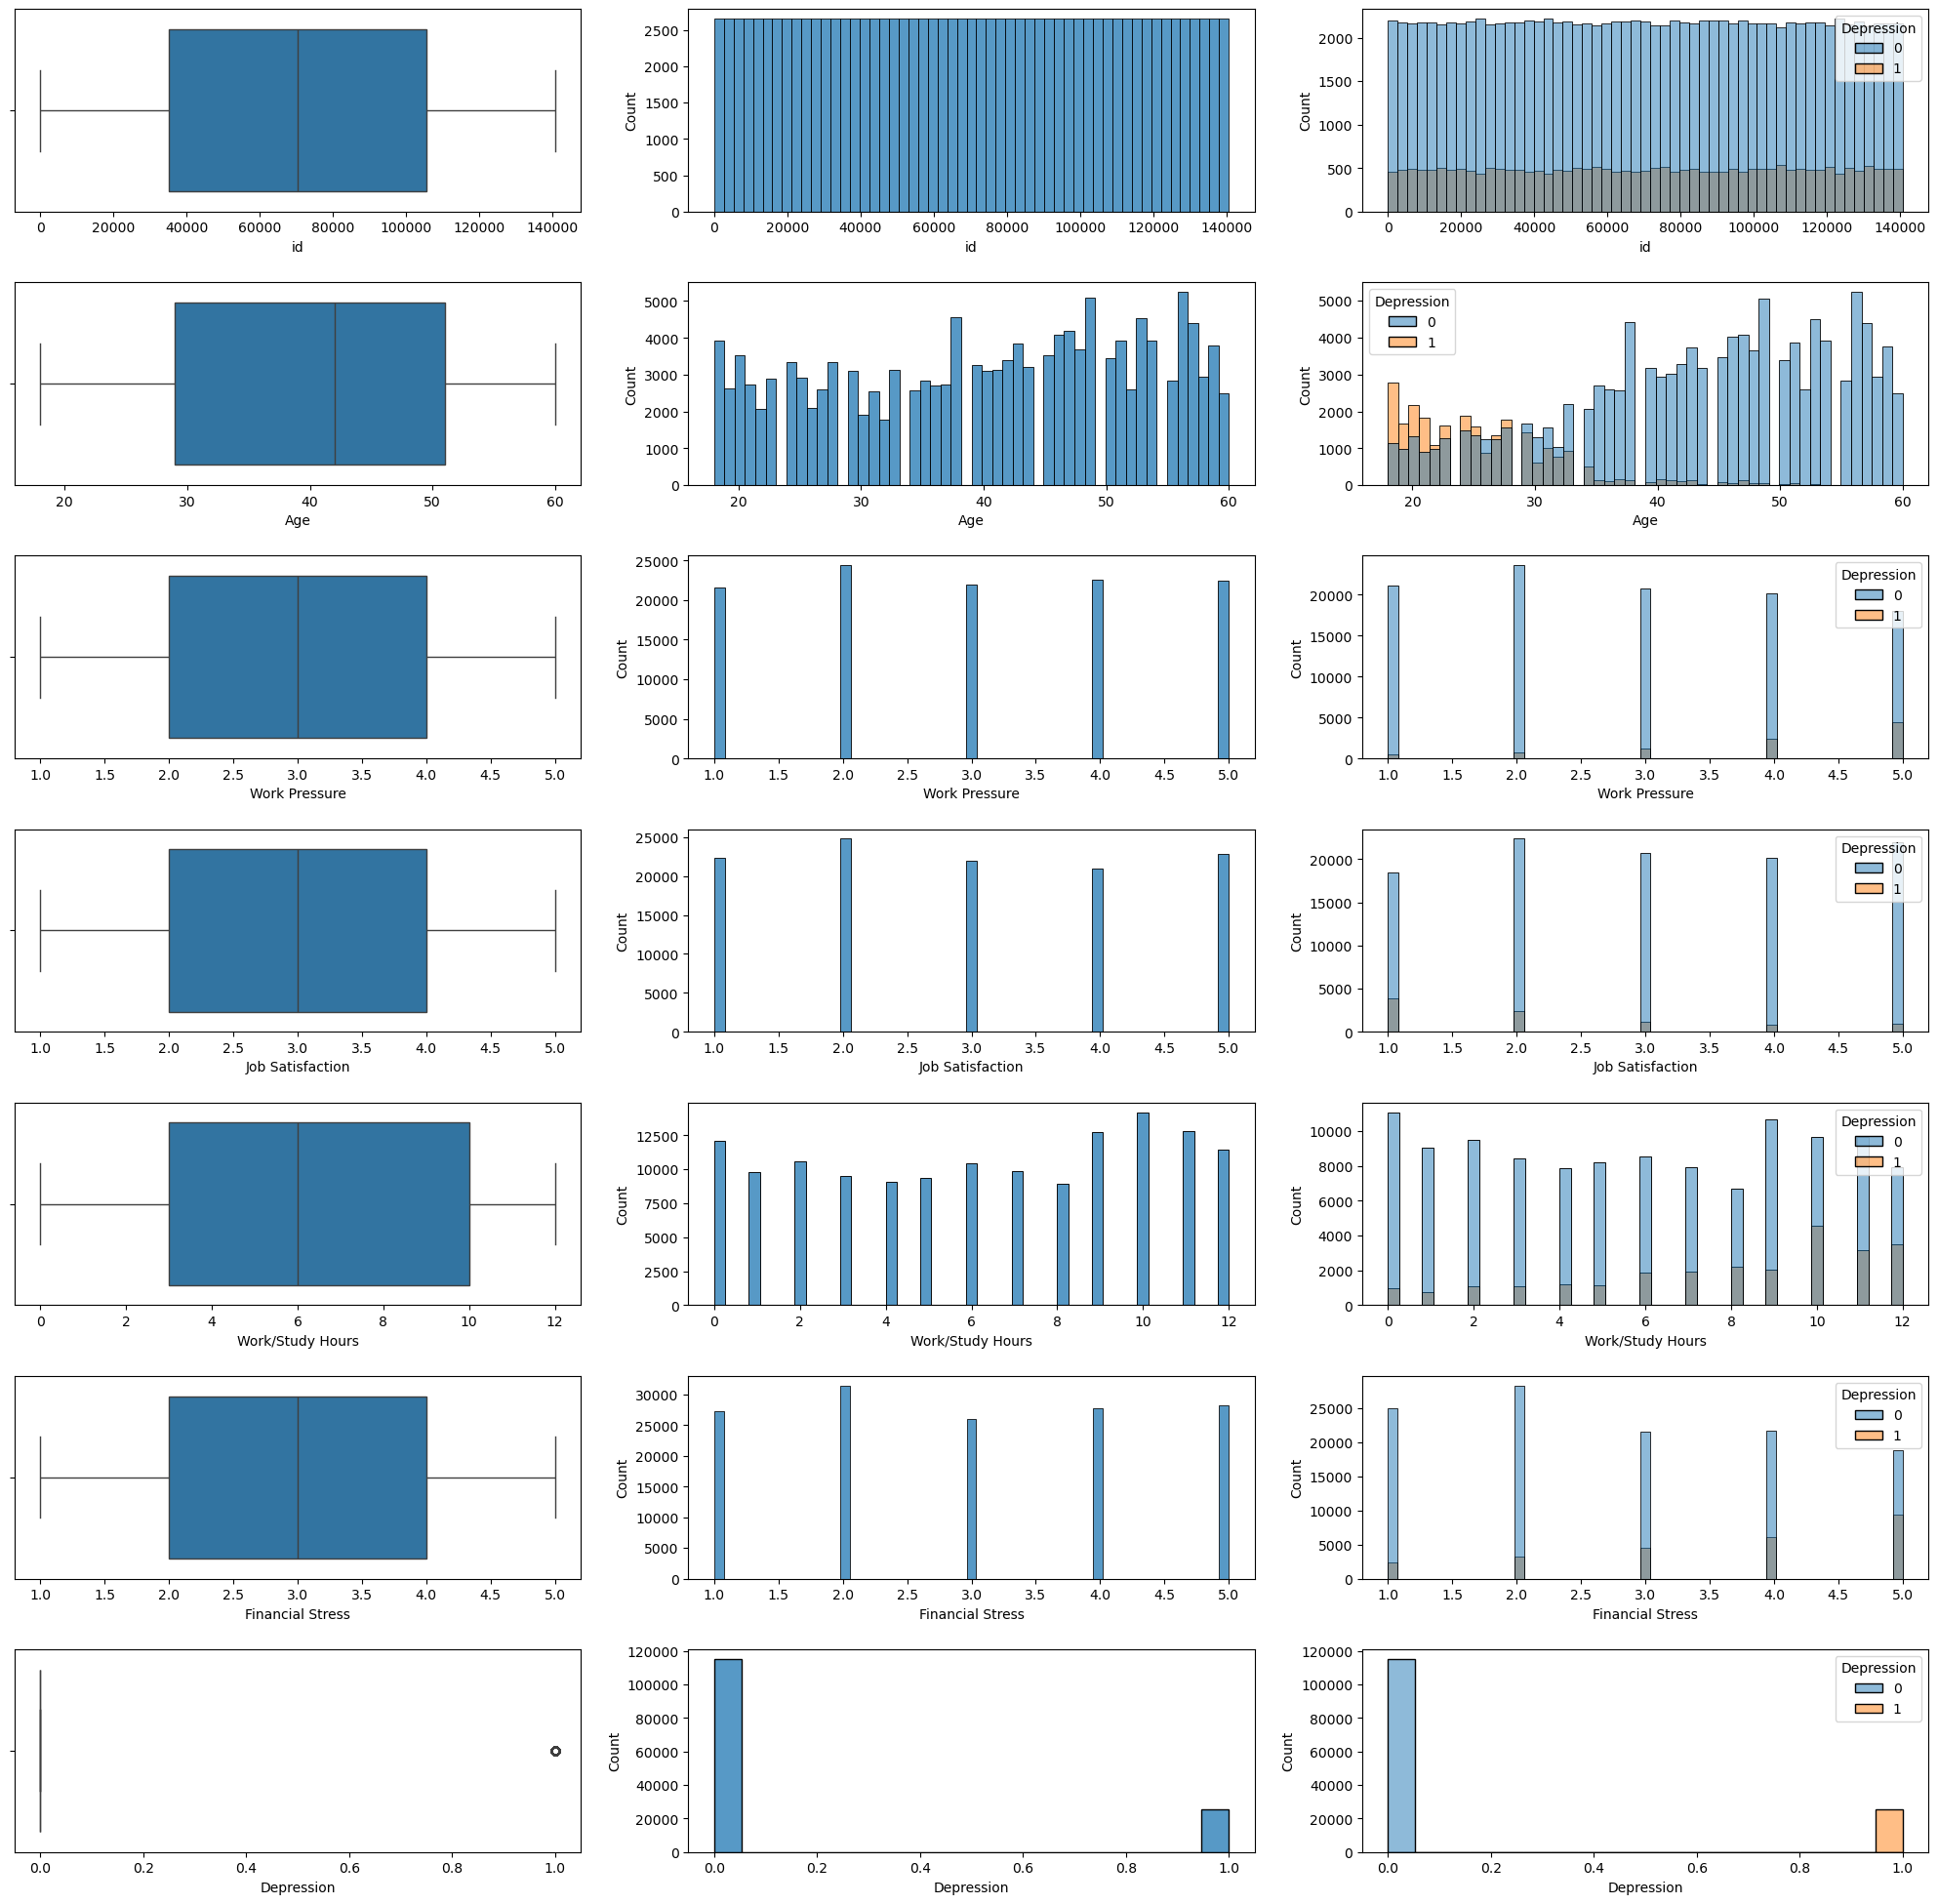

In [46]:
Numeric_viz(after_drops,3,'Depression')

In [32]:
after_drops.select_dtypes(exclude='object').columns
#for drop id

Index(['id', 'Age', 'Work Pressure', 'Job Satisfaction', 'Work/Study Hours',
       'Financial Stress', 'Depression'],
      dtype='object')

In [ ]:
after_drops.drop(columns='id',inplace=True)

In [50]:
after_drops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 16 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   140700 non-null  object 
 1   Gender                                 140700 non-null  object 
 2   Age                                    140700 non-null  float64
 3   City                                   140700 non-null  object 
 4   Working Professional or Student        140700 non-null  object 
 5   Profession                             104070 non-null  object 
 6   Work Pressure                          112782 non-null  float64
 7   Job Satisfaction                       112790 non-null  float64
 8   Sleep Duration                         140700 non-null  object 
 9   Dietary Habits                         140696 non-null  object 
 10  Degree                                 140698 non-null  

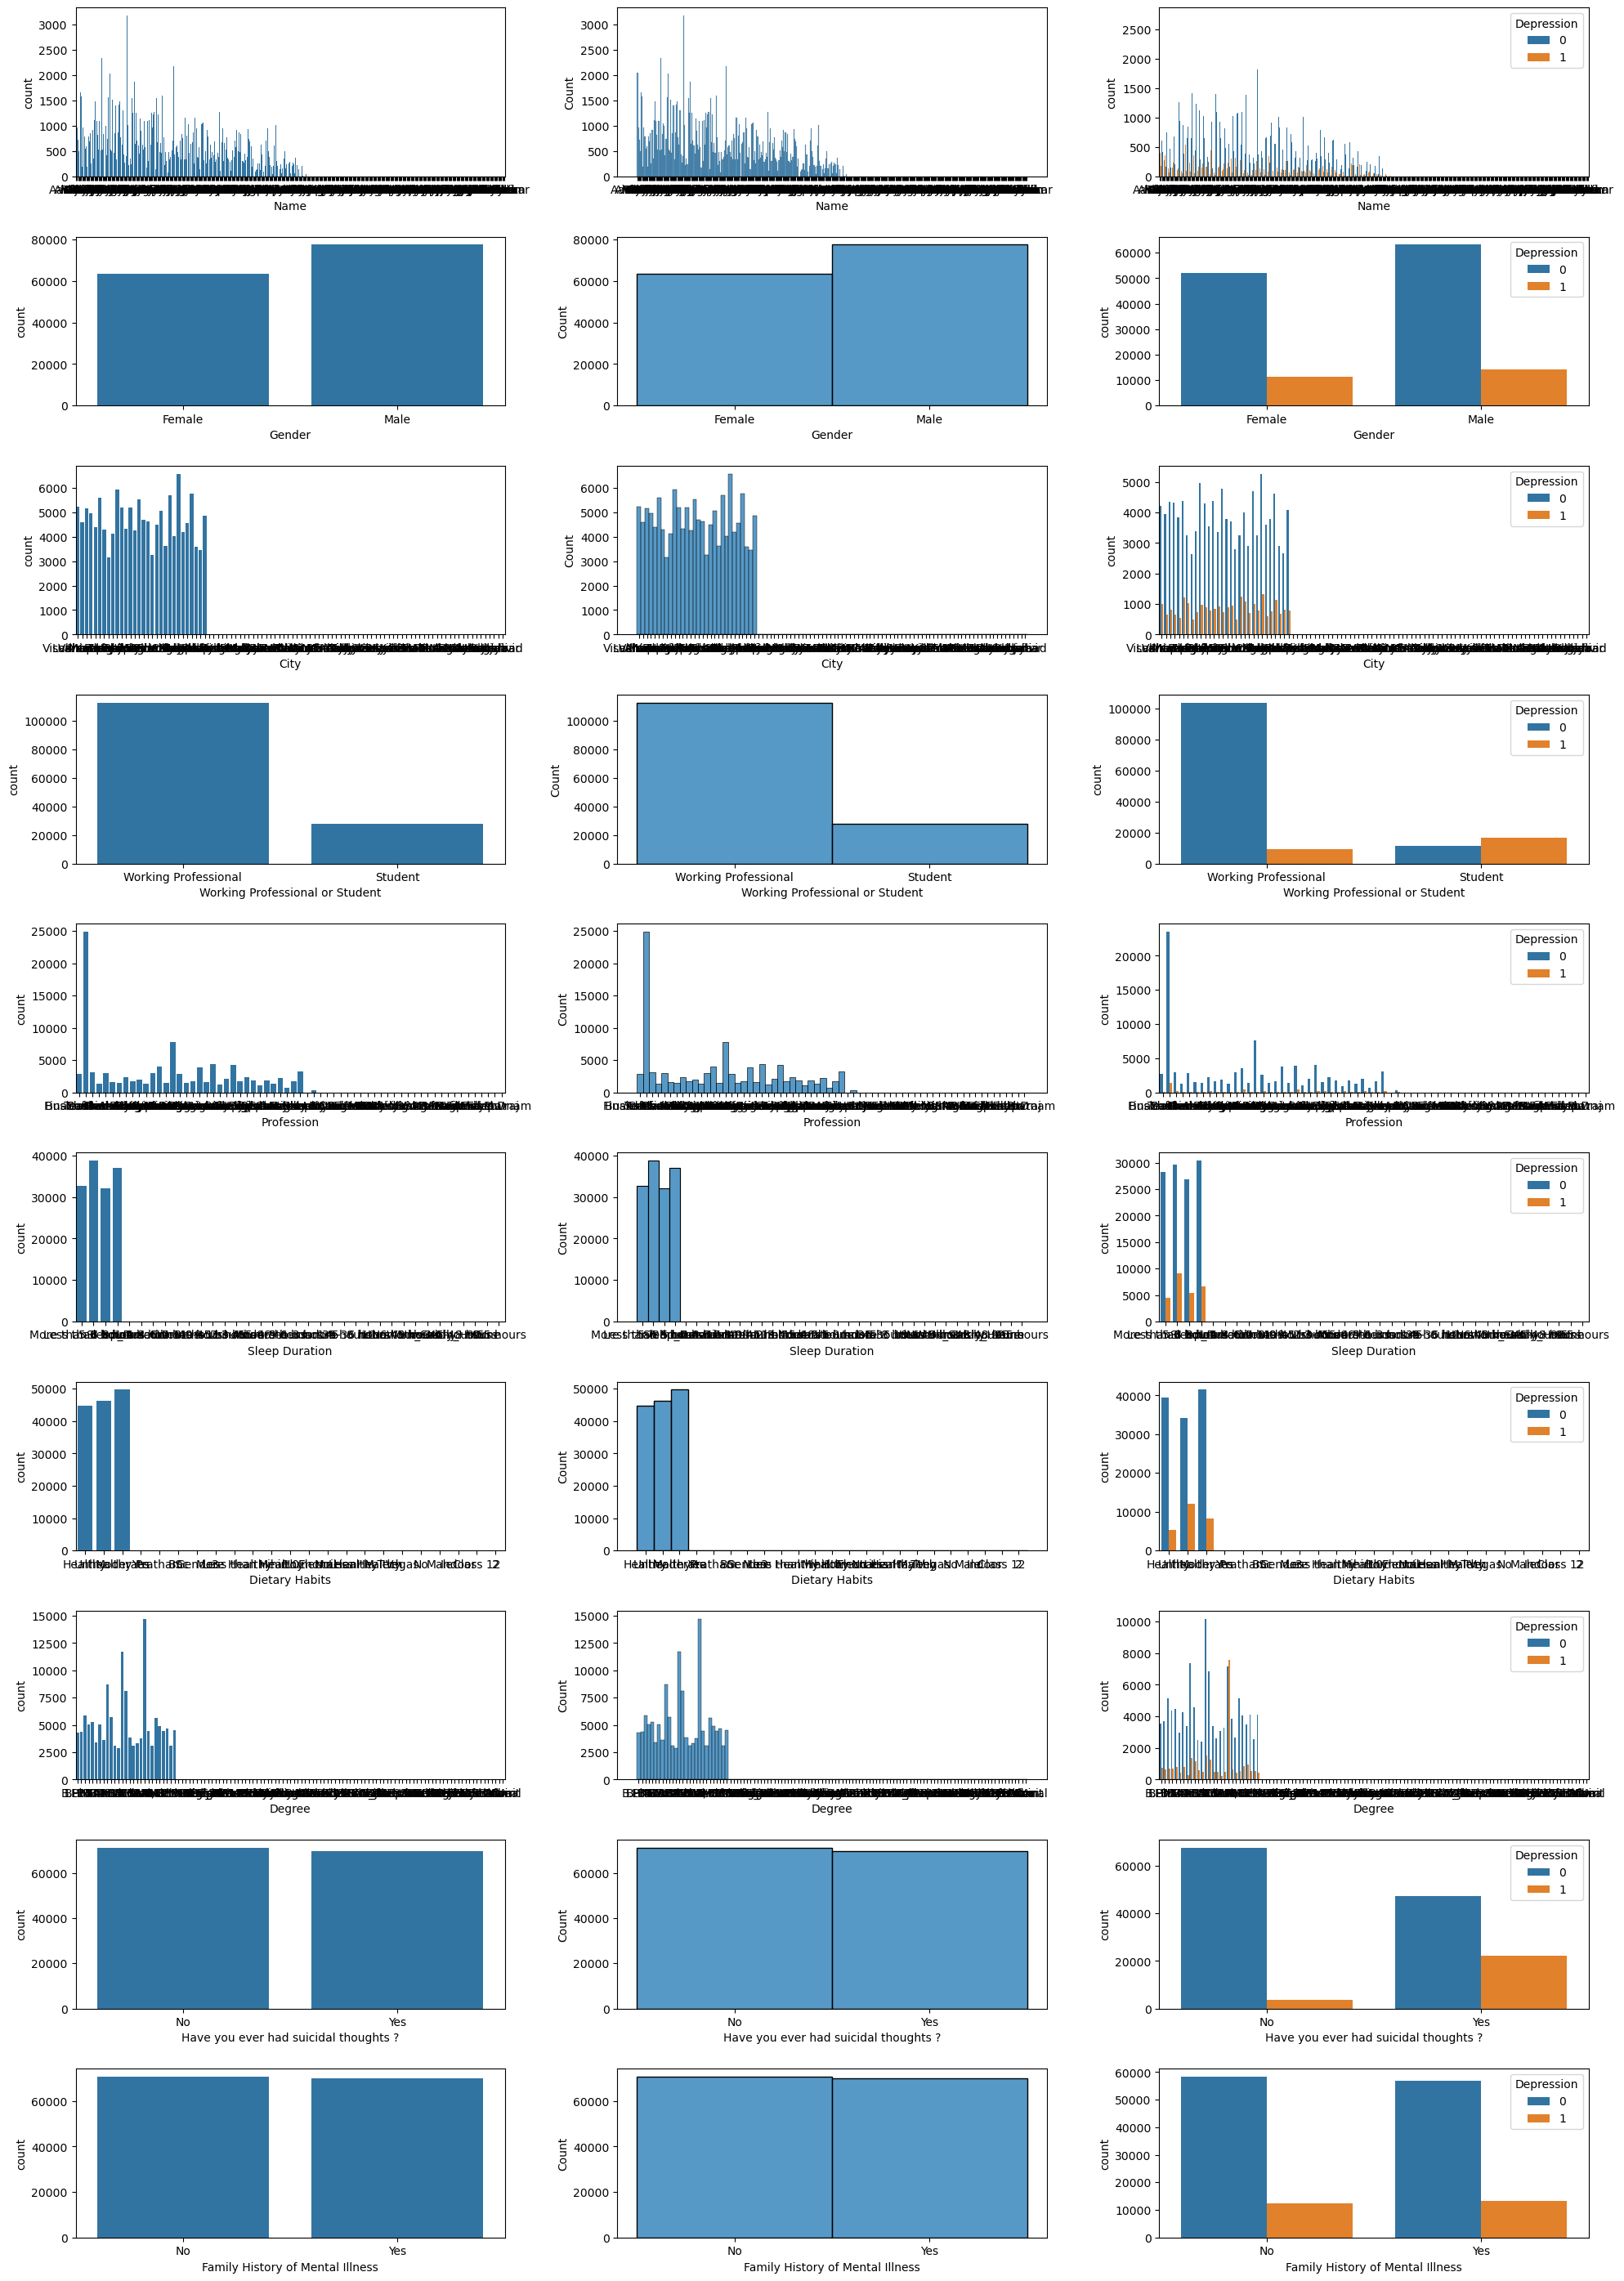

In [48]:
cat_viz(after_drops,3,'Depression')

In [31]:
after_drops.select_dtypes(include='object').columns

Index(['Name', 'Gender', 'City', 'Working Professional or Student',
       'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?',
       'Family History of Mental Illness'],
      dtype='object')

In [51]:
#for drop 'Name'
#for interesting 'Sleep Duration','Dietary Habits','Degree','City',
after_drops.drop(columns='Name',inplace=True)

In [68]:
after_drops['Profession'].unique()

array(['Chef', 'Teacher', nan, 'Business Analyst', 'Finanancial Analyst',
       'Chemist', 'Electrician', 'Software Engineer', 'Data Scientist',
       'Plumber', 'Marketing Manager', 'Accountant', 'Entrepreneur',
       'HR Manager', 'UX/UI Designer', 'Content Writer',
       'Educational Consultant', 'Civil Engineer', 'Manager',
       'Pharmacist', 'Financial Analyst', 'Architect',
       'Mechanical Engineer', 'Customer Support', 'Consultant', 'Judge',
       'Researcher', 'Pilot', 'Graphic Designer', 'Travel Consultant',
       'Digital Marketer', 'Lawyer', 'Research Analyst',
       'Sales Executive', 'Doctor', 'Unemployed', 'Investment Banker',
       'Family Consultant', 'B.Com', 'BE', 'Student', 'Yogesh', 'Dev',
       'MBA', 'LLM', 'BCA', 'Academic', 'Profession', 'FamilyVirar',
       'City Manager', 'BBA', 'Medical Doctor', 'Working Professional',
       'MBBS', 'Patna', 'Unveil', 'B.Ed', 'Nagpur', 'Moderate', 'M.Ed',
       'Analyst', 'Pranav', 'Visakhapatnam', 'PhD', 'Yu

In [54]:
gender_dict = {'Male':1,'Female':0}
suicidal_thoughts = {'Yes':1,'No':0}
Family_History = {'Yes':1,'No':0}

In [55]:
after_drops['Gender']=after_drops['Gender'].map(gender_dict)
after_drops['Have you ever had suicidal thoughts ?']=after_drops['Have you ever had suicidal thoughts ?'].map(suicidal_thoughts)
after_drops['Family History of Mental Illness']=after_drops['Family History of Mental Illness'].map(Family_History)

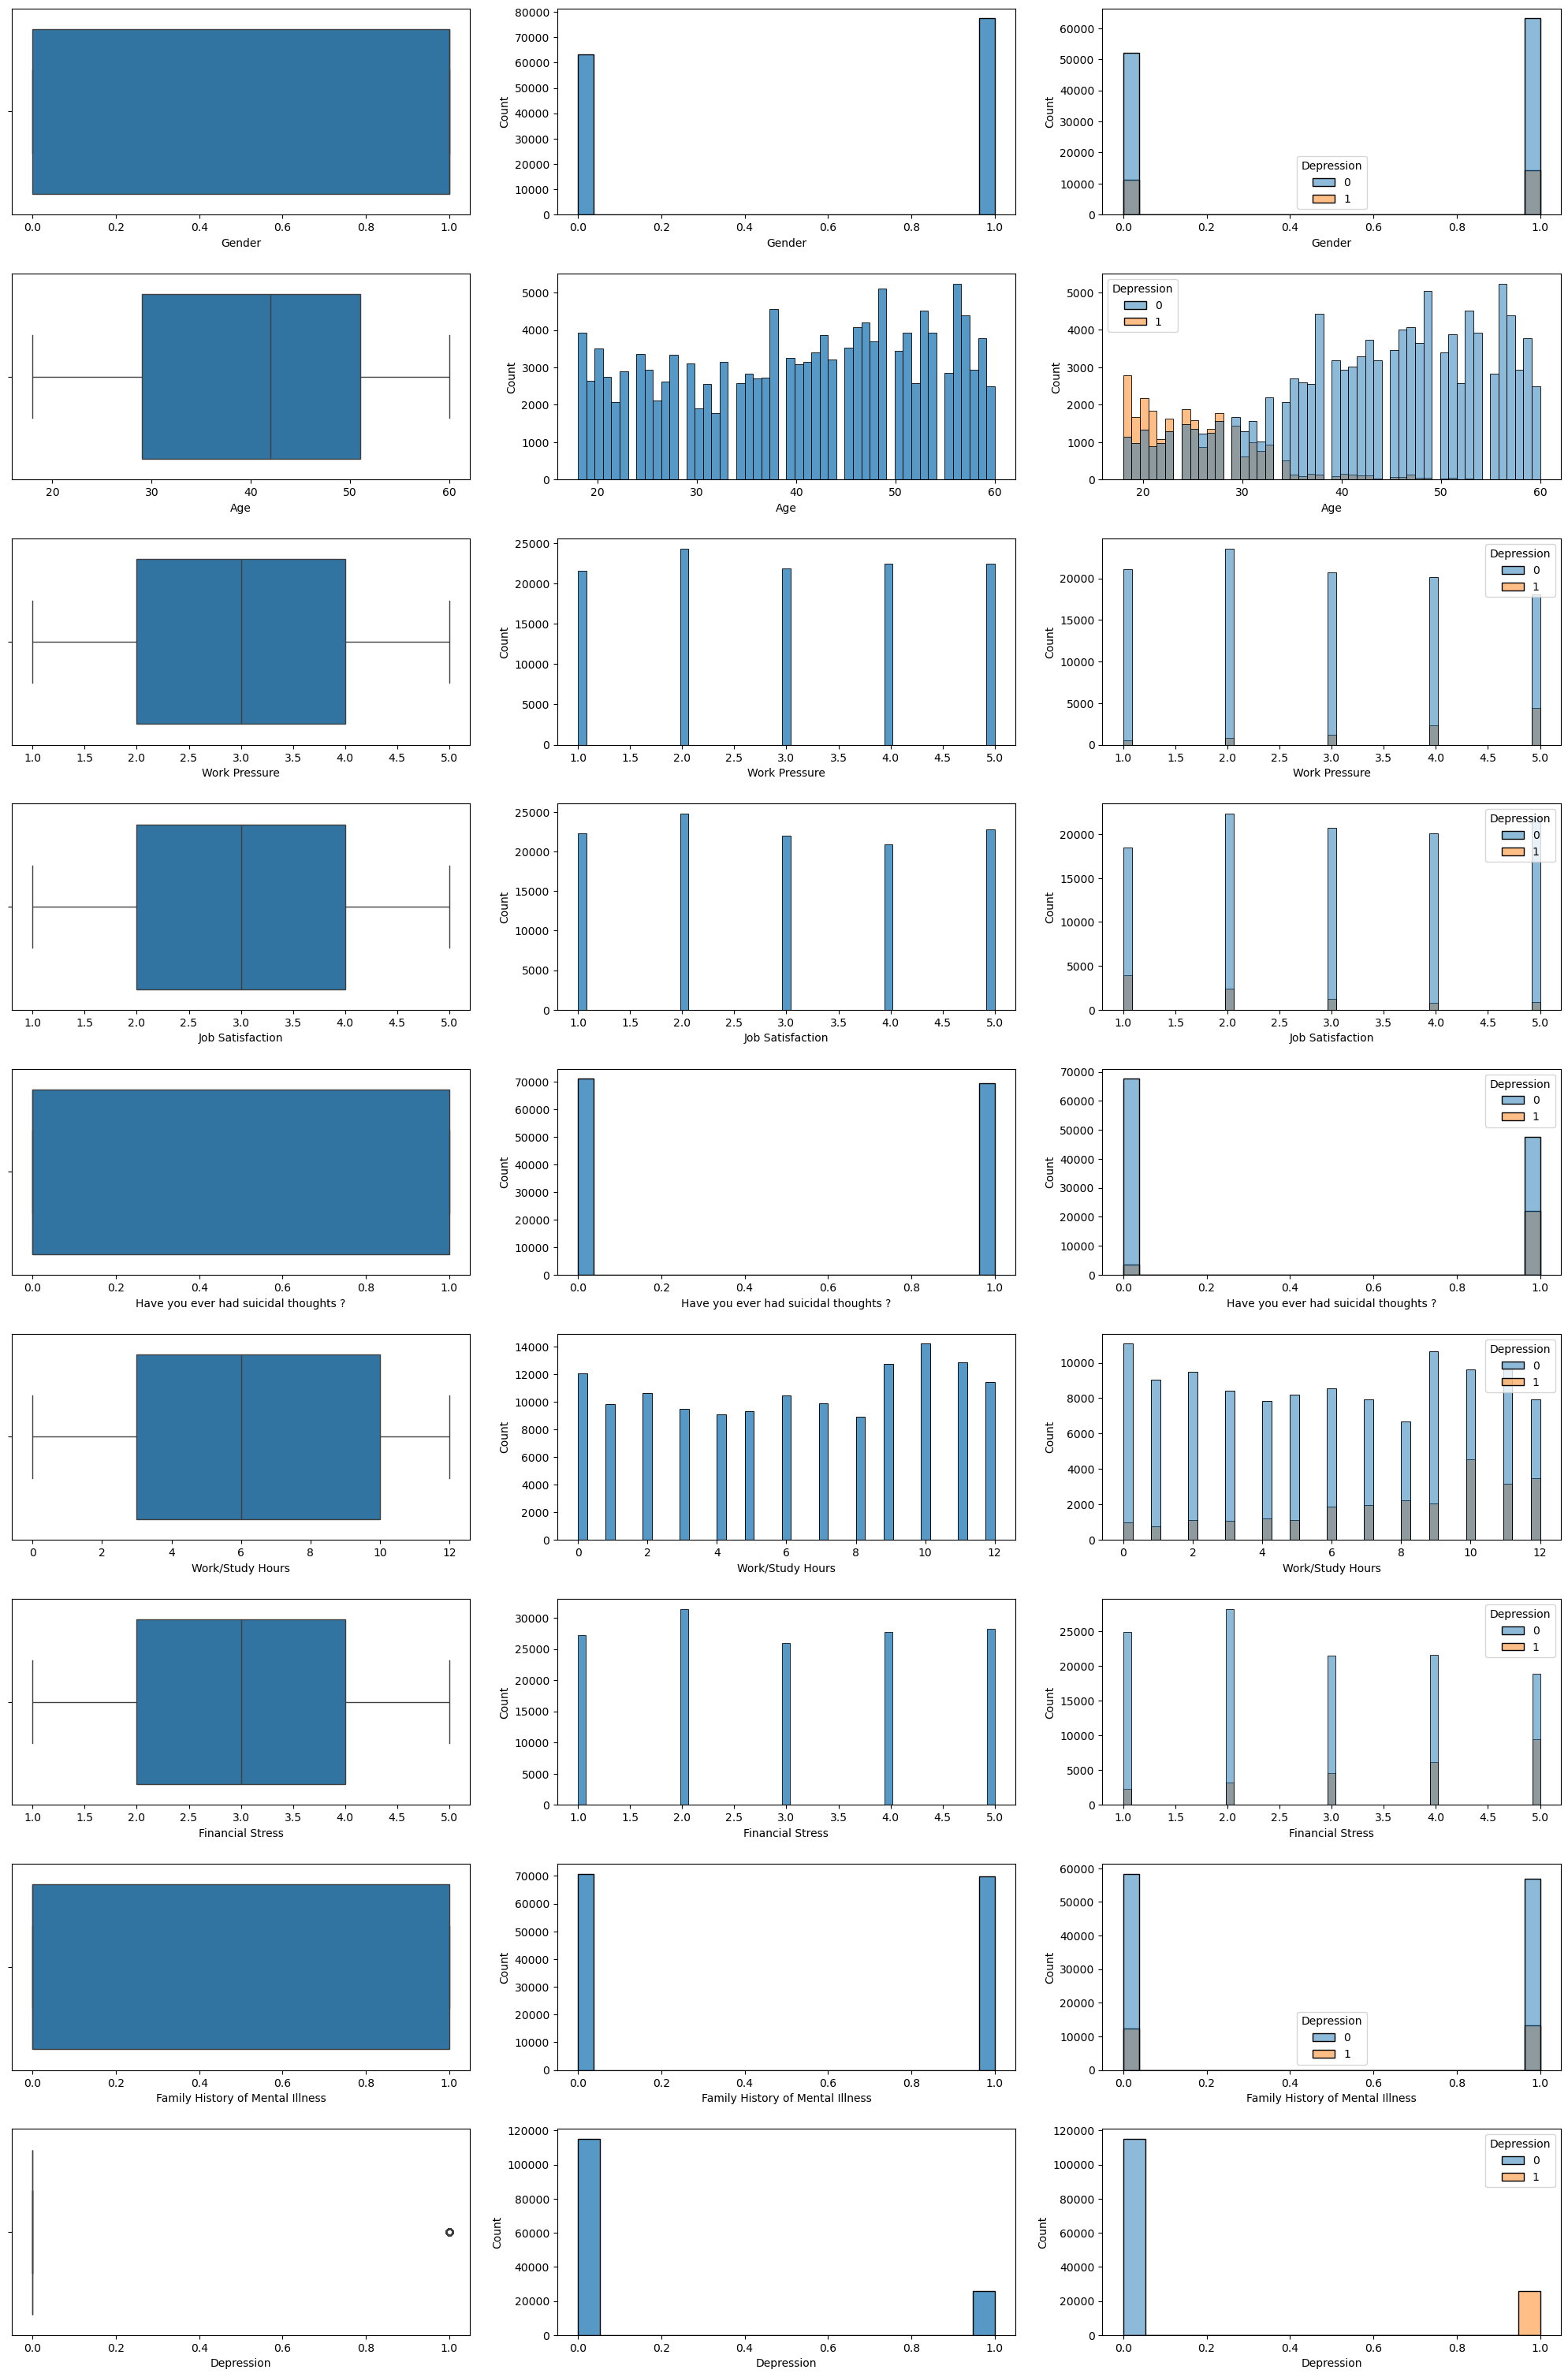

In [56]:
Numeric_viz(after_drops,3,'Depression')

In [ ]:
#Основные выводы по EDA 
# #Дисбаланс классов

In [ ]:
#Фича инжениринг и очистка данных
